In [268]:
import random

#random.seed(420)
random.seed(1)

"""
- borrow_amount
- last_repaid
- total_staked
- total_locked
- staked

"""
maxBorrow = 1000000
maxRepaid = 60 * 60 * 24 * 60 # 60 days
overdue = maxRepaid * 0.75
stakers = [{"staked_amount": random.randint(25 * maxBorrow, 35 * maxBorrow) } for i in range(25)]

for i in range(len(stakers)):
    borrowers = [{"borrow_amount": random.randint(1, maxBorrow), "last_repaid": random.randint(1, maxRepaid)} for i in range(25)]
    stakers[i]["borrowers"] = borrowers
    stakers[i]["locked"] = sum([borrower["borrow_amount"] for borrower in borrowers])
    stakers[i]["frozen"] = sum([borrower["borrow_amount"] if borrower["last_repaid"] > overdue else 0 for borrower in borrowers])
    
total_staked = sum([staker["staked_amount"] for staker in stakers])
total_borrowed = sum([sum([borrower["borrow_amount"] for borrower in staker["borrowers"]]) for staker in stakers])
total_frozen = sum([staker["frozen"] for staker in stakers])

print(f"total_staked: {total_staked}")
print(f"total_borrowed: {total_borrowed}")
print(f"total_frozen: {total_frozen}")

total_staked: 735910771
total_borrowed: 323733531
total_frozen: 81588934


In [269]:
"""
Calculate multipliers the old way

function _getRewardsMultiplier(
    uint256 userStaked,
    uint256 lockedStake,
    uint256 totalFrozen_,
    bool isMember_
) private pure returns (uint256) {
    if (!isMember_) {
        return nonMemberRatio;
    }
        
    if (userStaked == 0 || totalFrozen_ >= lockedStake || totalFrozen_ >= userStaked) {
        return memberRatio;
    }

    uint256 effectiveLockedAmount = lockedStake - totalFrozen_;
    uint256 effectiveStakeAmount = userStaked - totalFrozen_;

    uint256 lendingRatio = effectiveLockedAmount.wadDiv(effectiveStakeAmount);

    return lendingRatio + memberRatio;
}

"""
member_ratio = 1

def getRewardsMultiplier(staked, locked_stake, frozen_stake):
    if staked == 0 or frozen_stake >= locked_stake or frozen_stake >= staked:
        return member_ratio
    
    effective_locked_amount = locked_stake - frozen_stake
    effective_stake_amount = staked - frozen_stake
    
    lending_ratio = effective_locked_amount / effective_stake_amount
    
    return lending_ratio + member_ratio

for staker in stakers:
    staker["old_multiplier"] = getRewardsMultiplier(staker["staked_amount"], staker["locked"], staker["frozen"])

In [278]:
"""
Calculate multipliers the new way

1 2 3 4 5 6 7 8 9
    |   |       |
    
(5 - 3) / (9 - 3) = 0.16666
"""
import math

# first we calculate each stakers coinage
for staker in stakers:
    staker["coinage"] = sum([borrower["borrow_amount"] / borrower["last_repaid"] for borrower in staker["borrowers"]])

total_coinage = sum([staker["coinage"] for staker in stakers])
print(f"total_coinage: {total_coinage}")

def getRewardsMultiplierNew(coinage, staked, locked):
    # TODO: what about staked vs total staked
    # TODO: what about locked value
    ave_coinage = total_coinage / len(stakers)
    lo = ave_coinage - ave_coinage
    hi = ave_coinage + ave_coinage
    coinage = min(max(lo, coinage), hi)
    
    k = ((coinage - lo) / (hi - lo))
    j = locked / staked
    
    return 1 + 0.5 * (k + j)
    
for staker in stakers:
    staker["new_multiplier"] = getRewardsMultiplierNew(staker["coinage"], staker["staked_amount"], staker["locked"])

total_coinage: 376.4075883255024


diffs: 9
----
staked: 27254257, locked: 15919119, frozen: 4957251
staked: 25426910, locked: 14911059, frozen: 1942978
----
staked: 32541208, locked: 14328703, frozen: 3815561
staked: 33312021, locked: 13516440, frozen: 4303443
----
staked: 31368886, locked: 11083207, frozen: 4470980
staked: 32922960, locked: 9943454, frozen: 3190271
----
staked: 32260626, locked: 12991113, frozen: 3882743
staked: 31539906, locked: 12938560, frozen: 881768
----
staked: 34917908, locked: 11413637, frozen: 2447630
staked: 28837993, locked: 11356687, frozen: 2376839
----
staked: 26715087, locked: 12665255, frozen: 3992738
staked: 34917908, locked: 11413637, frozen: 2447630
----
staked: 25374502, locked: 14765794, frozen: 3097434
staked: 25513214, locked: 11925186, frozen: 4702099
----


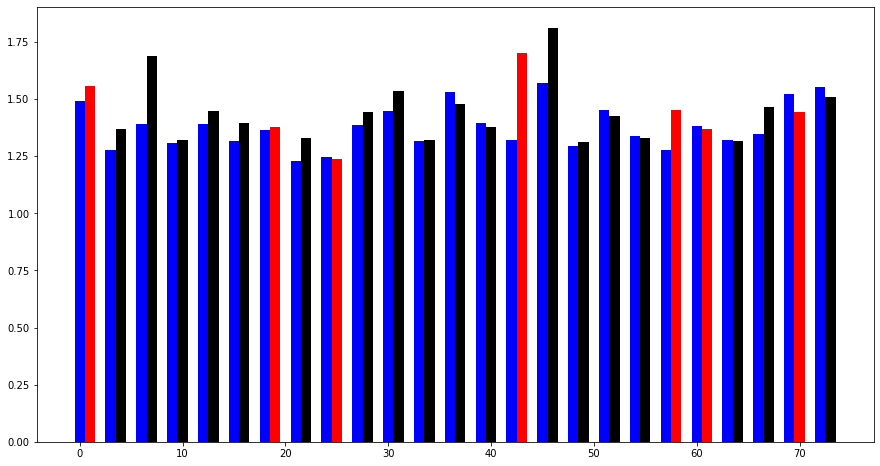

In [279]:
import matplotlib.pyplot as plt

debug = False
plt.figure(figsize=(15,8))

diffs=[]

for i in range(0, len(stakers) * 3, 3):
    idx = int(i/3)
    
    old = stakers[idx]['old_multiplier']
    old_b = stakers[idx-1]['old_multiplier']

    new = stakers[idx]['new_multiplier']
    new_b = stakers[idx-1]['new_multiplier']
    
    color="black"
    if (old > old_b and new < new_b) or (old < old_b and new > new_b):
        diffs.append({ "c": stakers[idx], "p": stakers[idx-1]})
        color="red"
            
    plt.bar(i, old, 1, color="blue")
    plt.bar(i+1, new, 1, color=color)
    if debug:
        print("------")
        print(f"old_multiplier: {staker['old_multiplier']}")
        print(f"new_multiplier: {staker['new_multiplier']}")

print(f"diffs: {len(errors)}")
print("----")
for diff in diffs:
    print(f"staked: {diff['c']['staked_amount']}, locked: {diff['c']['locked']}, frozen: {diff['c']['frozen']}")
    print(f"staked: {diff['p']['staked_amount']}, locked: {diff['p']['locked']}, frozen: {diff['p']['frozen']}")
    print("----")